#Installing Dependencies without a tensorflow.gpu


In [1]:
!pip install tensorflow==2.16.1 opencv-python matplotlib

Importing Dependencies

In [93]:
import cv2 # Import open cv into notebook.
import os # Operating system library.
import random # Optional - If testing / generating data, comes in handy.
import numpy as np # Helps work with tensors and workign with arrays.
from matplotlib import pyplot as plt #Want to use plot.imshow to see images.

In [3]:
# Import tensorflow dependencies
# One show classification via a siamese neural network...?
# View this research paper for more information about siamese neural networks when working with image recognition.
# Paper link: https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf
# Two inputs: passing in two images at the same time. There exists a distance layer, which will then test the similarities
# betweent the two images.
# Very similar -> output a 1
# Very different -> output a 0

In [4]:
#Importing functional API components

In [94]:
from tensorflow.keras.models import Model #Allows us to do something like Model(inputs=[inputs, verificationimage], outputs=[1,0])
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten #Conv. NN tools
import tensorflow as tf

In [95]:
# If ther exists a GPU, run this block: Memory ocnsumption growth setup
gpus = tf.config.experimental.list_physical_devices('GPU') #accessing all gpus on the machine.
for gpu in gpus:
    tf.config.experimental.set_memory_groeth(gpu, True)

In [96]:
POS_PATH = os.path.join('data', 'positive') # returns data\\positive
NEG_PATH = os.path.join('data', 'negative') # returns data\\negative
ANC_PATH = os.path.join('data', 'anchor') # returns data\\anchor

In [13]:
# Making directories in the file directory
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [Errno 17] File exists: 'data/positive'

In [8]:
# Now im going to collect the images via the image data. Recall that I need 3 different categories image data
# Positive images, negative inages and anchor images.
# 1. Anchor (Input Image, in this case from webcam) into a model encoding, compared to
# 2. Positive (Pos. Image) into the model encoding and comparing the two.
# Via siamese NN,  we pass both into a distance layer to see how similar they are, which in return will output 1 or a 0
# If 1, then the person in webcam is the same person in the positive image.

# Similar process for the negatvie case, however the distance layer will then output a 0

HUGE NOTE: We will only be using a single person (me) for the anchor. However we can (if desired) implement the same program for multiple people.


In [9]:
# Now , I will perform some data collection for the anchors, positive and negative image data.
# Recall: Anchor data will come from the webcam (using the OpenCV package)
# Positive data will also some from the webcam
# Negative data will come from the labelled faces in a wild dataset.

In [10]:
# For negative faces, here is the data set: http://vis-www.cs.umass.edu/Lfw/
# Download the one titled "All images as gzipped tar file" 173 MB

In [14]:
# Untar the labelled faces in the Wild Dataset
!tar -xf lfw.tgz

In [97]:
# Move the Images into the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [ ]:
# Now using openCV, I will collect data though my webcam.
# Note that I only want to collect images of size 250x250 pixels, to match the size of the iamges in the LFW data set.

In [98]:
# Data Collection for anchor and positive folders. I collected about 400 images per folder.
# Note that you should only run this function once per every 15 images per folder, i.e. run this function approximately 27 times. (sorry)
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from PIL import Image as PilImage
import os
import time
from io import BytesIO

# Directory paths
anchor_path = "/content/data/anchor"
positive_path = "/content/data/positive"
os.makedirs(anchor_path, exist_ok=True)
os.makedirs(positive_path, exist_ok=True)

def take_photos(quality=0.8):
    js = Javascript('''
    async function takePhotos(quality) {
        const div = document.createElement('div');
        const captureAnchor = document.createElement('button');
        captureAnchor.textContent = 'Capture Anchor';
        const capturePositive = document.createElement('button');
        capturePositive.textContent = 'Capture Positive';
        const stop = document.createElement('button');
        stop.textContent = 'Stop';
        div.appendChild(captureAnchor);
        div.appendChild(capturePositive);
        div.appendChild(stop);

        document.body.appendChild(div);

        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

        let photos = [];

        captureAnchor.onclick = () => capture('anchor');
        capturePositive.onclick = () => capture('positive');

        function capture(type) {
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            const dataUrl = canvas.toDataURL('image/jpeg', quality);
            photos.push({type: type, dataUrl: dataUrl});
        }

        stop.onclick = () => {
            stream.getVideoTracks()[0].stop();
            div.remove();
            return photos;
        };

        return new Promise((resolve) => stop.addEventListener('click', () => resolve(photos)));
    }
    ''')
    display(js)
    return eval_js('takePhotos({})')

def save_photos(photo_data):
    counter = 1  # Initialize a counter to ensure unique filenames
    for data in photo_data:
        binary = b64decode(data['dataUrl'].split(',')[1])
        img = PilImage.open(BytesIO(binary))

        # Crop and resize the image
        crop_area = (200, 120, 450, 370)  # Adjusted to crop the specific area
        cropped_img = img.crop(crop_area)
        resized_img = cropped_img.resize((250, 250), PilImage.ANTIALIAS)

        directory = f"/content/data/{data['type']}"
        timestamp = int(time.time())
        filename = f"{directory}/{timestamp}_{counter}.jpg"
        resized_img.save(filename)  # Save the cropped and resized image
        print(f"Saved {filename}")
        counter += 1

# Capture and save the photos
photo_data = take_photos()
save_photos(photo_data)


<IPython.core.display.Javascript object>

In [99]:
import os

folder_path = '/content/data/positive'
num_files = len([name for name in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, name))])
print(num_files)

400


In [100]:
# Now want to use a tensorflow data loader to process the images using data pipelines
# First get the images
# Using a wildcard, grab everything in the file path with a jpg extension and store into the variable.
# Also note that we want a matching number of samples for each data variables
anchor  = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(400)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(400)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(400)

In [101]:
dir_test = anchor.as_numpy_iterator()

In [102]:
dir_test.next()

b'data/anchor/1712436246_4.jpg'

In [103]:
# Now I want to proprocess all of my image data to make the gradient descent and
# the machine learning process easier.

In [104]:
# This function will scale and re-size the data using a map method, re-scaling image between 0 and 1.
def preprocess(file_path):

    # Read in image from file path
    byte_img = tf.io.read_file(file_path)

    # Load in the image
    img = tf.io.decode_jpeg(byte_img)

    # Preprocessing steps - re-sizing the iamge to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1
    img = img / 255.0
    #Returning image
    return img

In [105]:
img = preprocess('data/anchor/1712436367_13.jpg')

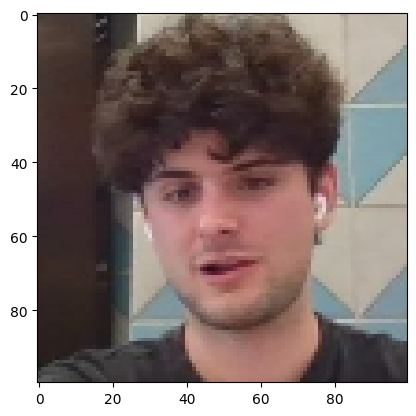

In [106]:
plt.imshow(img)

In [107]:
# Now I want to create the labelled datasets. 1 for positives and 0 for negatives
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [108]:
# Now I want to build, train and test partition.
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [109]:
# Building the data pipeline... last prep for training
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size = 1024)

In [87]:
# Creating a training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [113]:
# Creating a Testing Partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

**Machine Learning Portion - **

Building an embedding layer

Creating an L1 Distance Layer

Compile the Siamese Network

In [145]:
# Function that builds the embedding layer
# ReLU activation, takes 64 pixels, with filter of 10x10, stride = 1
# Recall the paper for the specific convolutions, activations functions and dimensions
# Sequence: inp->c1->m1->c2->m2->c3->m3->c4->f1->d1
def make_embedding():
    #Input
    inp = Input(shape=(100,100,3), name='input_image')

    #First Block
    # Convolution with ReLU activation
    c1 = Conv2D(64, (10,10), activation = 'relu')(inp)
    # MaxPooling
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    #Second Block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    #Third Block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    #Fourth Block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)

    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [146]:
#Summary of the entire convolution.

#First Block
inp = Input(shape=(100,100,3), name='input_image')
# Convolution with ReLU activation
c1 = Conv2D(64, (10,10), activation = 'relu')(inp)
# MaxPooling
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

#Second Block
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

#Third Block
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

#Fourth Block
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [147]:
embedding = make_embedding()

In [154]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [193]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super(L1Dist, self).__init__(**kwargs)

    def call(self, inputs):
        # Unpack the inputs list to individual tensors
        input_embedding, validation_embedding = inputs
        return tf.math.abs(tf.math.subtract(input_embedding, validation_embedding))

In [197]:
def make_siamese_model():
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100, 100, 3))

    # Validation image in the network
    validation_image = Input(name='validation_img', shape=(100, 100, 3))

    # Process both inputs through the same embedding model
    anchor_embedding = embedding(input_image)
    validation_embedding = embedding(validation_image)

    # Combine siamese distance components
    siamese_layer = L1Dist()
    distances = siamese_layer([anchor_embedding, validation_embedding])  # Correctly pass inputs as a list

    # Classification Layer
    classifier = Dense(1, activation='sigmoid')(distances)

    # Construct and return the Siamese Network model
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [198]:
siamese_model = make_siamese_model()

In [199]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)    │ (None, 100, 100, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ validation_img            │ (None, 100, 100, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Functional)    │ (None, 4096)           │     38,960,448 │ input_img[0][0],       │
│                           │                        │                │ validation_img[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l1_dist_14 (L1Dist)       │ (1, None, 4096)        │              0 │ embedding[24][0],      │
│                           │                        │                │ embedding[25][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (1, None, 1)           │          4,097 │ l1_dist_14[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

Now I want to set up a loss function, set up an optimizer, build a custom training setup and train the model.

In [237]:
# Setting up the loss function and optimizer
# What if logits = true??? No because our values are already floats for the resulting probabilities.
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [238]:
# Now, lets define our optimizer, here I will use an Adam optimizer with a learning rate of 1e-4
opt = tf.keras.optimizers.Adam(1e-4)

In [239]:
# Now, Im going to establish a checkpoint callback
# Note that to reload from the checkpoint you can use model.load('path_to_checkpoint')
# The line above will load the pre traine weights into the existing model.
#Directory where we will save all of the checkpoints.
checkpoint_dir = './training_checkpoints'
#Prefix all checkpoints with 'ckpt'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
#Saving opt and siamese_model as the checkpoints.
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [256]:
# Now I want to build / train using a step function.
# The flow for training on one batch is: prediction, calculate loss, derive gradiencts, calculate new weights and apply
@tf.function #Decorator - Compiles a function into a callable Tensorflow graph
def train_step(batch):

    #Records operations for automatic differentiation
    with tf.GradientTape() as tape:

        #Get anchor and positive/negative image
        X = batch[:2]
        #Get label
        y = batch[2]

        #Forward pass to the siamese neural network
        yhat = siamese_model(X, training=True)
        #Calculate the loss... want to pass a y_true value and a y_pred value, i.e. the actual y and the predicted y
        loss = binary_cross_loss(y, tf.squeeze(yhat))
    print(loss)

    #Now calcualte the gradients.
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    #Calculate updated weights and apply to siamese model
    #Note that the optimizer here is calculating and propagating the new weights using Adams optimization algorithm , a varient of gradient descent.
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    return loss

In [257]:
# Now I want to build the training loop
# Note that the train_step funciton was focused on training for one batch, the loop here will be used to iterate over every batch in the dataset.
def train(data, EPOCHS):
    #Loop though the EOPCHS
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

    #Loop though each batch
    for idx, batch in enumerate(data):
        #Run train step here.
        train_step(batch)
        progbar.update(idx+1)

    #Save checkpoints approximately every  10 epochs
    if epoch % 10 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)


In [258]:
# Now lets train the model
EPOCHS = 50

In [259]:
train(train_data, EPOCHS)


 Epoch 1/50

 Epoch 2/50

 Epoch 3/50

 Epoch 4/50

 Epoch 5/50

 Epoch 6/50

 Epoch 7/50

 Epoch 8/50

 Epoch 9/50

 Epoch 10/50

 Epoch 11/50

 Epoch 12/50

 Epoch 13/50

 Epoch 14/50

 Epoch 15/50

 Epoch 16/50

 Epoch 17/50

 Epoch 18/50

 Epoch 19/50

 Epoch 20/50

 Epoch 21/50

 Epoch 22/50

 Epoch 23/50

 Epoch 24/50

 Epoch 25/50

 Epoch 26/50

 Epoch 27/50

 Epoch 28/50

 Epoch 29/50

 Epoch 30/50

 Epoch 31/50

 Epoch 32/50

 Epoch 33/50

 Epoch 34/50

 Epoch 35/50

 Epoch 36/50

 Epoch 37/50

 Epoch 38/50

 Epoch 39/50

 Epoch 40/50

 Epoch 41/50

 Epoch 42/50

 Epoch 43/50

 Epoch 44/50

 Epoch 45/50

 Epoch 46/50

 Epoch 47/50

 Epoch 48/50

 Epoch 49/50

 Epoch 50/50
Tensor("binary_crossentropy/Mean:0", shape=(), dtype=float32)
35/35 ━━━━━━━━━━━━━━━━━━━━ 849s 24s/step


Now I want to test the model, evaluate the perfomance and save the model for deployment.

In [268]:
#Now I want to evaluate the model using precision and recall.
#Im not going to import the required packages
#Precision demonstrates what proportion of positive identifications were actually correct.
#Recall shows what proportion of actual positives were identified correctly.
from tensorflow.keras.metrics import Precision, Recall

In [269]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [283]:
# Making predictions.
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


array([[[6.0525602e-01],
        [7.2643811e-01],
        [9.1151424e-02],
        [1.4481126e-02],
        [2.4376985e-02],
        [2.7220148e-01],
        [5.0168794e-01],
        [5.5190116e-01],
        [5.0271207e-01],
        [8.0419677e-01],
        [3.1812438e-01],
        [3.2121569e-04],
        [2.4235882e-03],
        [2.9533278e-04],
        [5.2268463e-01],
        [3.9164303e-03]]], dtype=float32)

In [293]:
# Post processing the results.
processed_results = [[1 if element > 0.5 else 0 for element in prediction] for prediction in y_hat]
processed_results

[[1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0]]

In [294]:
y_true

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0.],
      dtype=float32)

THESE MATCH VERY VERY WELL!


In [300]:
# Creating a metric object for recall
r = Recall()

#Update the state, or calculating the recall value, passing y_true and y_hat
r.update_state(y_true, y_hat)

#Accessing the result, converting to a numpy value
print('recall:', r.result().numpy())

##############

#Similar metric for precision

# Creating a metric object for precision
p = Precision()

#Update the state, or calculating the precision value, passing y_true and y_hat
p.update_state(y_true, y_hat)

#Accessing the result, converting to a numpy value
print('precision:', p.result().numpy())

recall: 1.0
precision: 1.0


^^ if 1.0, this implies 100%, which was what I got.

HUGE NOTE: This was the result for a single batch...

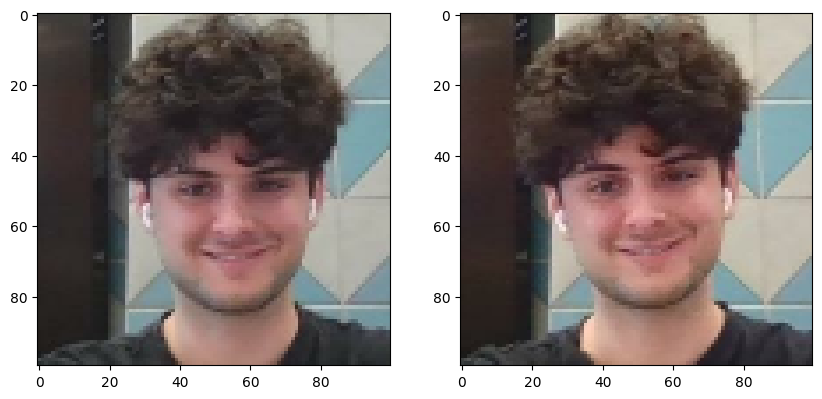

In [303]:
 # Lets visual the results now.
 plt.figure(figsize=(10,8))
 plt.subplot(1,2,1)
 plt.imshow(test_input[0])
 plt.subplot(1,2,2)
 plt.imshow(test_val[0])
 plt.show()

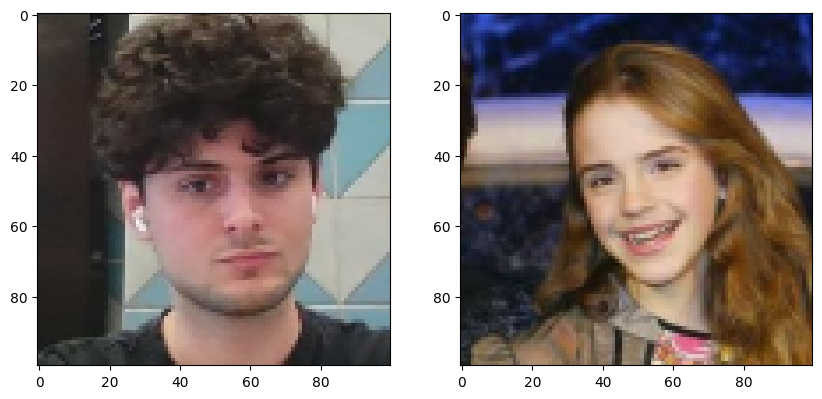

In [304]:
 # Lets visual the results now.
 plt.figure(figsize=(10,8))
 plt.subplot(1,2,1)
 plt.imshow(test_input[2])
 plt.subplot(1,2,2)
 plt.imshow(test_val[2])
 plt.show()

In [319]:
#Now I want to save the model
#Save the weights
siamese_model.save('siamesemodel.h5')

NameError: name 'model' is not defined

In [320]:
# Reloading the model
siamese_model.load_weights

NameError: name 'model' is not defined

In [318]:
siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[[6.0525602e-01],
        [7.2643811e-01],
        [9.1151424e-02],
        [1.4481126e-02],
        [2.4376985e-02],
        [2.7220148e-01],
        [5.0168794e-01],
        [5.5190116e-01],
        [5.0271207e-01],
        [8.0419677e-01],
        [3.1812438e-01],
        [3.2121569e-04],
        [2.4235882e-03],
        [2.9533278e-04],
        [5.2268463e-01],
        [3.9164303e-03]]], dtype=float32)